In [39]:
import xlrd
import xlwt
import numpy as np
import statsmodels.api as sm
import patsy
from pandas.core.frame import DataFrame
import scipy.stats as st

In [40]:
workBook = xlrd.open_workbook('第五章数据（第四版）.xlsx');

# 1.获取sheet的名字
# 1.1 获取所有sheet的名字(list类型)
allSheetNames = workBook.sheet_names();
print(allSheetNames);

# 1.2 按索引号获取sheet的名字（string类型）
sheet1Name = workBook.sheet_names()[2];
# print(sheet1Name);

# # 2. 获取sheet内容
# ## 2.1 法1：按索引号获取sheet内容
sheet1_content1 = workBook.sheet_by_index(2); # sheet索引从0开始

# 4. 获取整行和整列的值（数组）
Y=sheet1_content1.col_values(1)[2:];
X2 = sheet1_content1.col_values(2)[2:]; # 获取第三列内容
print(Y)
print(X2)

['案例表5.1', '表5.3', '表5.4', '表5.5', '表5.6']
[6046.22, 2986.45, 3972.66, 2324.91, 1394.68, 6217.52, 1626.65, 2029.16, '4586.2.8 ', 15122.85, 14907.42, 3597.26, 3692.62, 2095.47, 6482.9, 5279.36, 5586.45, 3915.02, 5774.01, 1553.07, 255.47, 3328.83, 5256.65, 824.72, 1868.4, 124.47, 3216.63, 925.84, 319.42, 427.92, 1320.37]
[216.78, 79.54, 127.0, 49.22, 105.37, 224.31, 89.03, 58.92, 166.69, 595.87, 411.57, 127.12, 126.47, 62.37, 291.77, 200.09, 231.46, 124.77, 251.69, 26.24, 6.44, 155.34, 177.19, 14.39, 61.88, 5.75, 104.38, 29.33, 8.35, 11.25, 27.6]


In [64]:
import numpy as np
import pandas as pd
import scipy.stats as st

class mul_linear_model(object):
    #intercept定义是否有截距项，在计量经济分析中，基本都要有截距项，否则计算出的拟合优度是没有意义的
    def __init__(self, y, X, intercept=True):
        data_x = X.copy()
        data_y = y.copy()
        self.data_x = data_x
        self.y = np.array(data_y)
        self.intercept = intercept
        
        if intercept == False:
            self.columns = data_x.columns
            self.X = np.mat(data_x)
        else:
            #插入截距项
            data_x.insert(0,'intercept',np.ones(len(data_x)))   
            #每个变量名称
            self.columns = data_x.columns
            #转换为矩阵，方便后面运算
            self.X = np.mat(data_x)
        
        #X的转置，方便后面运算
        self.XT=np.mat(self.X).T 
        self.N = self.X.shape[0]   #样本量
        self.K = self.X.shape[1]  #变量个数
    
    #拟合模型
    def fit(self, output=True):
        #使用最小二乘法(X'X)的逆成X'y
        self.b = np.array(np.dot(np.dot(np.linalg.inv(np.dot(self.XT,self.X)),self.XT),np.mat(self.y).T))
        if output:
            for i in range(self.K):
                print("variable {0}'s cofe estimate is : {1}".format(self.columns[i], self.b[i][0]))
        
        self.S = np.array(np.linalg.inv(np.dot(self.XT,self.X)))
        return self.b
    
    #预测函数
    def predict(self, X_p):
        #直接使用条件期望作y=Xb为预测值
        y_hat =np.array(np.dot(X_p,self.b))
        return y_hat
    
    #参数T检验
    def T_test(self, alpha):
        #计算预测值
        y_hat = np.array(np.dot(self.X,self.b).T)[0]
        #计算e'e,即残差平方和
        error_square = np.sum(np.square(y_hat-self.y))
        #计算扰动项的方差估计,即残差平方和
        sigma_hat = error_square/(self.N-self.K)
        #计算(X'X)的逆，用于估计参数b的方差
        #S = self.S
        for i in range(self.K):
            sk = self.S[i][i]
            #b的方差估计为sigma_hat * sk，构造t统计量，服从自由度为n-k的T分布
            Tk = self.b[i][0]/np.sqrt(sigma_hat * sk)
            #查表进行检验
            if abs(Tk) > abs(st.t.ppf(alpha/2, df = self.N-self.K)):
                print("T of variable {0} is: {1}, refuse H0".format(self.columns[i], Tk))
            else:
                print("T of variable {0} is: {1}, can't refuse H0".format(self.columns[i], Tk))
                
    #拟合优度计算
    def R_square(self):
        y_ba = np.mean(self.y)
        y_hat = np.array(np.dot(self.X,self.b).T)[0]
        #计算总平方和
        self.SST = np.sum(np.square(self.y-y_ba))
        #计算误差平方和
        self.SSE = np.sum(np.square(self.y-y_hat))
        #计算离差平方和
        self.SSR = self.SST - self.SSE
        #利用拟合优度公式计算拟合优度
        self.R_2 = self.SSR/self.SST
        
        return self.R_2
    
    #整体F检验
    def F_test(self, alpha):
        #先求出拟合优度
        self.R_square()
        #利用公式求F统计量，附送自由优度为(K-1, N-K)的F分布
        F = (self.R_2/(self.K-1))/((1-self.R_2)/(self.N-self.K))
        #查表进行检验
        if abs(F) > abs(st.f.ppf(1-alpha, dfn = self.K-1, dfd = self.N-self.K)):
            print("F of function is: {0}, refuse H0".format(F))
        else:
            print("F of function is: {0}, can't refuse H0".format(F))
    
    def data_relation(self):
        if self.intercept:
            return self.data_x.loc[:,self.data_x.columns!='intercept'].corr()
        else:
            return self.data_x.corr()
        
        
    
    def VIF_cul(self, ind):
        #使用最小二乘法(X'X)的逆成X'y
        yk = np.array(self.X[:, ind].T)
        #有截距项时：
        if self.intercept:
            Xk = self.X[:, [i for i in range(1,ind)]+[j for j in range(ind+1, self.K)]]
        #无截距项时：
        else:
            Xk = self.X[:, [i for i in range(ind)]+[j for j in range(ind+1, self.K)]]
        
        vif_model = mul_linear_model(yk, pd.DataFrame(Xk), intercept=False)
        vif_model.fit(output=False)
        Rk_2 = vif_model.R_square()
        VIF_k = 1/(1-Rk_2)
        return VIF_k
        
    
    def VIF_test(self):
        for i in range(1, self.K):
            VIF_k = self.VIF_cul(i)
            print("variable {0}'s VIF estimate is : {1}".format(self.columns[i], VIF_k))
    
    def condition_num(self):
        if self.intercept:
            M = np.dot(self.XT[[i for i in range(1, self.K)],:], self.X[:, [j for j in range(1, self.K)]])
        else:
            M = np.dot(self.XT, self.X)
        eigenvalue, eigenvector = np.linalg.eig(M)
        cond_num = np.sqrt(eigenvalue[0]/eigenvalue[-1])
        print("data X's condition number is: {0}".format(cond_num))
    
    #岭回归
    def Ridge_fit(self, k = 0.1):
        #使用岭回归(X'X+kI)的逆成X'y
        self.b = np.array(np.dot(np.dot(np.linalg.inv(np.dot(self.XT,self.X)+np.mat(np.eye(self.K))),self.XT),self.y).T)
        
        for i in range(self.K):
            print("variable {0}'s cofe estimate is: {1}".format(self.columns[i], self.b[i][0]))
        
        self.S = np.array(np.dot(np.dot(np.linalg.inv(np.dot(self.XT,self.X)+np.mat(np.eye(self.K))), np.dot(self.XT,self.X)), np.linalg.inv(np.dot(self.XT,self.X)+np.mat(np.eye(self.K)))))
        
        return self.b
    
    #异方差怀特检验
    def White_test(self, alpha):
        #算出y_hat
        y_hat = np.array(np.dot(self.X,self.b).T)[0]
        #计算偏差
        e = y_hat-self.y
        import matplotlib.pyplot as plt
        plt.plot(e)
        plt.title('ei')
        #计算white检验的自变量white_x,包括每一个x,和x的平方，以及两两之间的交叉项
        white_x = self.data_x.copy()
        x_columns = white_x.columns
        #计算平方项与交叉项，第一列是截距项，无需计算
        for i in range(1, len(x_columns)):
            for j in range(1, i+1):
                white_x[x_columns[i]+'*'+x_columns[j]] = white_x[x_columns[i]]*white_x[x_columns[j]]
        
        #调用自身类，进行回归求R2,white_x已经包含截距项，无需再添加截距项
        white_model = mul_linear_model(e, white_x, intercept=False)
        #求回归参数
        white_model.fit(output=False)
        #求拟合优度
        white_R_2 = white_model.R_square()
        #计算统计量自由度
        white_df = white_model.K-1
        #计算white统计量
        white = white_model.N*white_R_2
        #进行假设检验
        if white > st.chi2.ppf(1-alpha, df = white_df):
            print("white statistic is: {0}, refuse H0".format(white))
        else:
            print("white statistic is: {0}, can't refuse H0".format(white))
    
    #自相关DW检验
    def DW_test(self):
        #算出y_hat
        y_hat = np.array(np.dot(self.X,self.b).T)[0]
        #计算偏差
        e = y_hat-self.y
        #得到当期残差e(t)
        e_t = e[1:len(e)]
        #得到前一期的残差e(t-1)
        e_tlag = e[0:len(e)-1]
        #进行回归求rou
        DW_model = mul_linear_model(e_t, pd.DataFrame(e_tlag), intercept=False)
        DW_model.fit(output=False)
        rou = DW_model.b[0][0]
        #利用dw统计量和rou的关系求出DW统计量
        d = 2*(1-rou)
        return d
    
    def gls_fit(self, output=True):
        #算出y_hat
        y_hat = np.array(np.dot(self.X,self.b).T)[0]
        #计算偏差
        e = y_hat-self.y
        #得到当期残差e(t)
        e_t = e[1:len(e)]
        #得到前一期的残差e(t-1)
        e_tlag = e[0:len(e)-1]
        #进行回归求rou
        DW_model = mul_linear_model(e_t, pd.DataFrame(e_tlag), intercept=False)
        DW_model.fit(output=False)
        rou = DW_model.b[0][0]
        
        #生成omiga矩阵过程
        relation_array=[]
        for i in range(len(self.y)):
            relation_array.append(pow(rou, i))
        
        omiga = [relation_array.copy()]
        
        for i in range(1, len(self.y)):
            relation_array = relation_array.copy()
            relation_array.insert(0, pow(rou, i))
            relation_array.pop()
            omiga.append(relation_array)
        #求出omiga矩阵
        omiga  = np.mat(omiga)
        #求出omiga矩阵的逆inv(omiga)
        omiga_inv = np.linalg.inv(omiga)
        
        #使用广义最小二乘法(X' inv(omiga) X)的逆成X'inv(omiga)y
        #np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(self.XT,omiga_inv), self.X)), self.XT), omiga_inv), np.mat(self.y).T)
        self.b = np.array(np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(self.XT,omiga_inv), self.X)), self.XT), omiga_inv), np.mat(self.y).T))
        
        if output:
            for i in range(self.K):
                print("variable {0}'s cofe estimate is : {1}".format(self.columns[i], self.b[i][0]))
        
        #需要注意的是，广义线性回归的方差会一起变
        self.S = np.array(np.linalg.inv(np.dot(np.dot(self.XT,omiga_inv), self.X)))
        return self.b


In [65]:
import pandas as pd
from sklearn.datasets import fetch_california_housing as fch

data=fch() #导入数据
house_data=pd.DataFrame(data.data) #将自变量转换成dataframe格式，便于查看
house_data.columns=data.feature_names  #命名自变量
house_data['value'] = data.target
house_data = house_data[0:100]
house_data = house_data[['value', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']]
print(house_data.head())


   value  HouseAge  AveRooms  AveBedrms  Population
0  4.526      41.0  6.984127   1.023810       322.0
1  3.585      21.0  6.238137   0.971880      2401.0
2  3.521      52.0  8.288136   1.073446       496.0
3  3.413      52.0  5.817352   1.073059       558.0
4  3.422      52.0  6.281853   1.081081       565.0


In [66]:
house_data[['HouseAge', 'AveRooms', 'AveBedrms', 'Population']]

HouseAge  AveRooms  AveBedrms  Population
0       41.0  6.984127   1.023810       322.0
1       21.0  6.238137   0.971880      2401.0
2       52.0  8.288136   1.073446       496.0
3       52.0  5.817352   1.073059       558.0
4       52.0  6.281853   1.081081       565.0
5       52.0  4.761658   1.103627       413.0
6       52.0  4.931907   0.951362      1094.0
7       52.0  4.797527   1.061824      1157.0
8       42.0  4.294118   1.117647      1206.0
9       52.0  4.970588   0.990196      1551.0
10      52.0  5.477612   1.079602       910.0
11      52.0  4.772480   1.024523      1504.0
12      52.0  5.322650   1.012821      1098.0
13      52.0  4.000000   1.097701       345.0
14      52.0  4.262903   1.009677      1212.0
15      50.0  4.242424   1.071970       697.0
16      52.0  5.939577   1.048338       793.0
17      52.0  4.052805   0.966997       648.0
18      50.0  5.343675   1.085919       990.0
19      52.0  5.465455   1.083636       690.0
20      40.0  4.524096   1.108434       409.0
21      42.0  4.478142   1.002732       929.0
22      52.0  5.096234   1.131799      1015.0
23      52.0  5.193846   1.036923       853.0
24      52.0  5.270142   1.035545      1006.0
25      41.0  4.495798   1.033613       317.0
26      49.0  4.728033   1.020921       607.0
27      52.0  4.780856   1.060453      1102.0
28      50.0  4.401691   1.040169      1131.0
29      52.0  4.703226   1.032258       395.0
..       ...       ...        ...         ...
70      26.0  6.047244   1.196850       392.0
71      46.0  3.375451   1.072202       582.0
72      49.0  5.552632   1.342105       560.0
73      46.0  1.714286   0.571429        18.0
74      20.0  6.278195   1.210526       290.0
75      17.0  2.817768   1.052392       762.0
76      36.0  5.724951   1.104126      1236.0
77      19.0  5.830918   1.173913       721.0
78      23.0  5.369231   1.150769      1054.0
79      38.0  4.412903   1.135484       344.0
80      17.0  3.197232   1.000000       609.0
81      52.0  3.750000   1.000000       183.0
82      52.0  3.908046   1.114943       200.0
83      52.0  2.490323   1.058065       346.0
84      35.0  5.609467   1.088757       467.0
85      52.0  6.721739   1.243478       377.0
86      40.0  2.315789   1.186842       582.0
87      10.0  2.651515   1.054545       546.0
88      10.0  2.692308   1.076923       125.0
89      52.0  2.929412   0.917647       396.0
90      16.0  2.745856   1.082873       800.0
91      52.0  2.443182   0.988636       904.0
92      52.0  2.823529   0.911765       191.0
93      27.0  3.493377   1.149007       718.0
94      39.0  3.672377   1.334047      1327.0
95      36.0  2.294016   1.066294      3469.0
96      31.0  3.894915   1.127966      2048.0
97      29.0  3.681319   1.175824       202.0
98      22.0  2.945600   1.016000      2024.0
99      37.0  3.707143   1.107143      1838.0

[100 rows x 4 columns]

variable intercept's cofe estimate is : 3.1977231939161825
variable HouseAge's cofe estimate is : -0.0018631823314009689
variable AveRooms's cofe estimate is : 0.19176276320081106
variable AveBedrms's cofe estimate is : -2.3833025289138488
variable Population's cofe estimate is : 0.00018533618793133673


T of variable intercept is: 4.7595579754498925, refuse H0
T of variable HouseAge is: -0.28155854174338957, can't refuse H0
T of variable AveRooms is: 2.676864302326245, refuse H0
T of variable AveBedrms is: -3.7735425397264475, refuse H0
T of variable Population is: 1.3025345625273101, can't refuse H0


R_2 estimate is: 0.15252060660600417 

F of function is: 4.274280218644267, refuse H0


white statistic is: 29.17906178214536, refuse H0




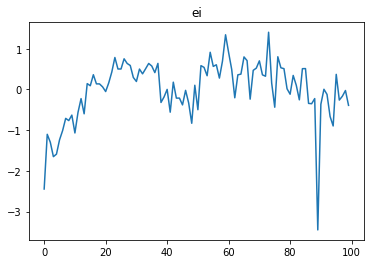

In [67]:
linear_model = mul_linear_model(house_data['value'],house_data[['HouseAge', 'AveRooms', 'AveBedrms', 'Population']])
linear_model.fit()
print('\n')
linear_model.T_test(0.05)
print('\n')
print("R_2 estimate is:", linear_model.R_square(), '\n')
linear_model.F_test(0.05)
print('\n')
    
linear_model.White_test(0.05)
print('\n')

In [68]:
linear_model = mul_linear_model(house_data['value'],house_data[['HouseAge', 'AveRooms', 'AveBedrms', 'Population']])
linear_model.fit(output = False)
dw = linear_model.DW_test()
linear_model.gls_fit()

variable intercept's cofe estimate is : 1.953098521983902
variable HouseAge's cofe estimate is : 0.007328267099636767
variable AveRooms's cofe estimate is : 0.09519415786079444
variable AveBedrms's cofe estimate is : -1.0698208284309456
variable Population's cofe estimate is : 2.7335031024503464e-05


array([[ 1.95309852e+00],
       [ 7.32826710e-03],
       [ 9.51941579e-02],
       [-1.06982083e+00],
       [ 2.73350310e-05]])